In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from queryLabel import Taxonomy
from utilities import printt

In [2]:
FILES_PATH = '/scratch/WikipediaImagesTaxonomy/commonswiki-20220220-files.parquet'
LGRAPH_PATH = '/scratch/WikipediaImagesTaxonomy/20220220-category-graph-wlabels_heuristics_simple_v1.0.pkl.bz2'
LGRAPH_H_PATH = '/scratch/WikipediaImagesTaxonomy/20220220-clean-graph-wlabels_heuristics_simple_v1.0.pkl.bz2'

In [3]:
files = pd.read_parquet(FILES_PATH)

In [4]:
printt('Loading graph...')
taxonomy = Taxonomy()
taxonomy.load_graph(LGRAPH_PATH)
taxonomy.load_graph(LGRAPH_H_PATH, clean=True)

15:50:56    Loading graph...


In [5]:
def queryFile(file, how='heuristics_simple'):
    '''
    Given one file, a row of the files DataFrame, queries recursively all
    the categories and returns the final labels.
    '''

    labels = set()
    for category in file.categories:
        cat_labels = taxonomy.get_label(category, how=how)
        labels |= cat_labels
    return labels

In [6]:
files['labels'] = files.progress_apply(lambda x: queryFile(x), axis=1)

100%|██████████| 3891446/3891446 [02:09<00:00, 30017.57it/s]


In [7]:
nb_labels_per_file = files.labels.apply(lambda x: len(x)).values

In [8]:
pd.Series(nb_labels_per_file).value_counts(normalize=True).sort_index()

0     0.174733
1     0.424596
2     0.215027
3     0.110834
4     0.048578
5     0.018109
6     0.005879
7     0.001731
8     0.000415
9     0.000080
10    0.000016
11    0.000003
dtype: float64

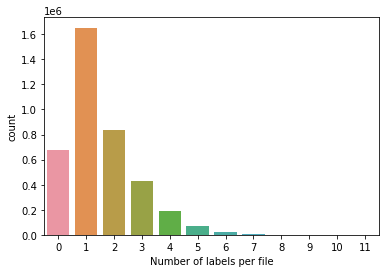

In [9]:
sns.countplot(x=nb_labels_per_file)
plt.xlabel('Number of labels per file')
plt.show()

In [12]:
labels_exploded = files.labels.apply(lambda x: list(x)).explode().values

In [69]:
counts = pd.Series(labels_exploded).value_counts()
counts

Places               1190819
Society               997846
Culture               661949
Objects               598750
People                590892
Nature                385957
History               367499
Sports                174802
Technology            159489
Politics              157146
Events                145907
Entertainment         105276
Art                    75398
Language               67056
Architecture           45306
Plants                 27715
Science                25970
Biology                22799
Music                  22102
Civil eng              21296
Flags                  18229
Landscapes             11500
Physics                 9162
Fossils                 8743
Chemistry               8652
Literature              7238
Animals                 6841
Astronomy               4550
Mathematics             3762
Earth sciences          1838
Engineering             1241
Marine organisms         965
Electrical eng           774
Mechanical eng           700
Food          

In [102]:
group_order = pd.Series(['Nature', 'Society/Culture', 'Science', 'Engineering'])

In [141]:
groups = pd.Series({'Nature': ['Nature', 'Animals', 'Fossils', 'Landscapes', 'Marine organisms', 'Plants', 'Weather'],
                    'Society/Culture': ['Society', 'Culture', 'Art', 'Belief', 'Entertainment', 'Events', 'Flags', 'Food', 'History', 
                    'Language', 'Literature', 'Music', 'Objects', 'People', 'Places', 'Politics', 'Sports'],
                    'Science': ['Science', 'Astronomy', 'Biology', 'Chemistry', 'Earth sciences', 'Mathematics',
                    'Medicine', 'Physics', 'Technology'],
                    'Engineering': ['Engineering', 'Architecture', 'Chemical eng', 'Civil eng', 'Electrical eng',
                      'Environmental eng', 'Geophysical eng', 'Mechanical eng', 'Process eng']})
groups = groups.reset_index().explode(column=0).reset_index().rename({'level_0': 'order', 'index': 'Group', 0: 'name'}, axis=1)#.set_index('name')
groups['count'] = counts.loc[groups.name.values].values
groups = groups.sort_values(by=['order', 'count'], ascending=[True, False])
groups.head()

,order,Group,name,count
0,0,Nature,Nature,385957
5,0,Nature,Plants,27715
3,0,Nature,Landscapes,11500
2,0,Nature,Fossils,8743
1,0,Nature,Animals,6841


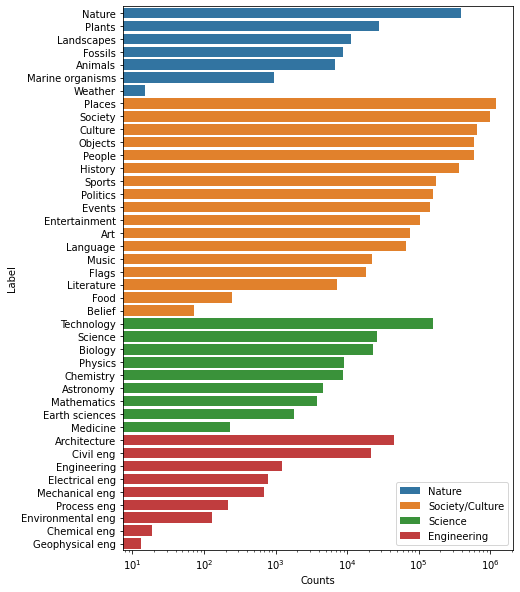

In [145]:
fig = plt.figure(figsize=(7, 10))
sns.barplot(y='name', x='count', hue='Group', data=groups, dodge=False)
plt.xscale('log')
plt.xlabel('Counts')
plt.ylabel('Label')
plt.legend(loc='lower right')
plt.show()